<a href="https://colab.research.google.com/github/kruthi03/wind-speed/blob/Stats%26ML/100001319_Exercise_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#laod the data set
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import r2_score, mean_squared_error
import shap
from sklearn.ensemble import RandomForestRegressor

# Load the dataset, specifying the encoding
data = pd.read_csv("epi_r.csv", encoding='latin-1') # or encoding='cp1252'
data.head()

,title,rating,calories,protein,fat,sodium,#cakeweek,#wasteless,22-minute meals,3-ingredient recipes,...,yellow squash,yogurt,yonkers,yuca,zucchini,cookbooks,leftovers,snack,snack week,turkey
0,"Lentil, Apple, and Turkey Wrap",2.500,426.0,30.0,7.0,559.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,Boudin Blanc Terrine with Red Onion Confit,4.375,403.0,18.0,23.0,1439.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Potato and Fennel Soup Hodge,3.750,165.0,6.0,7.0,165.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Mahi-Mahi in Tomato Olive Sauce,5.000,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Spinach Noodle Casserole,3.125,547.0,20.0,32.0,452.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
# Checking for missing values
missing = data.isnull().sum()
print(missing[missing > 0])

# data cleaning done by binniing method
numeric_data = data.select_dtypes(include=np.number)
data[numeric_data.columns] = numeric_data.fillna(numeric_data.median(), inplace=False) # handled missing values by impuatation method.

calories      157
protein       158
fat           158
sodium        158
yonkers         1
yuca            1
zucchini        1
cookbooks       1
leftovers       1
snack           1
snack week      1
turkey          1
dtype: int64


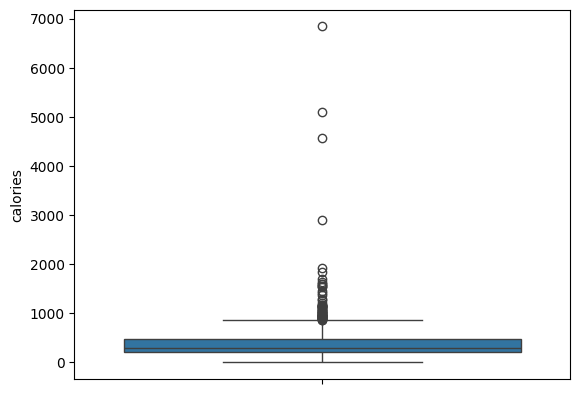

In [5]:
# Visualize outliers in a sample feature (e.g., 'calories')
sns.boxplot(data['calories'])
plt.show()

q1 = data['calories'].quantile(0.25)
q3 = data['calories'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
data['calories'] = np.where(data['calories'] > upper_bound, upper_bound, data['calories'])


In [6]:
# Select numerical features
numeric_features = data.select_dtypes(include=np.number).columns

#used scaling method to bring the features to one standardization value
scaler = StandardScaler()
data_scaled = data.copy()  # created dataframe - for numerical features
data_scaled[numeric_features] = scaler.fit_transform(data[numeric_features])

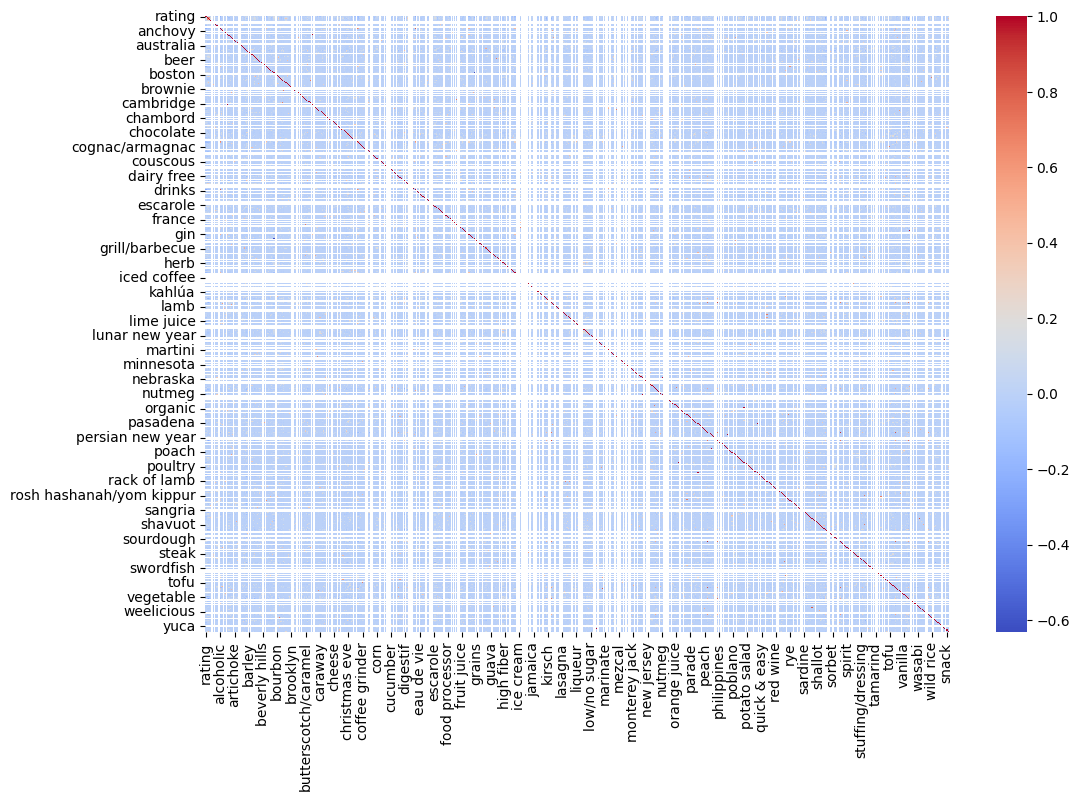

In [7]:
#using correlation method fpr feature selection
#only numerical features are selected for correlation calculation
numerical_data_scaled = data_scaled.select_dtypes(include=np.number)
#visualized using heatmap
corr_matrix = numerical_data_scaled.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap="coolwarm")
plt.show()

In [8]:
# Split the data
# Assuming 'title' and 'rating' are the outlier features
X = data_scaled.drop(columns=['title', 'rating', 'calories', 'protein', 'fat', 'sodium'])
y = data_scaled['rating'] # target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


X_selected = X_train

# Train Linear Regression model
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

# Evaluate
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Linear Regression -> R²: {r2:.2f}, RMSE: {rmse:.2f}")


# Cross-validation
cv_scores = cross_val_score(lr, X, y, cv=5, scoring='r2')
print(f"5-Fold CV R² Scores: {cv_scores}")
print(f"Mean CV R² Score: {np.mean(cv_scores):.2f}")

Linear Regression -> R²: -39231314547721976420331683840.00, RMSE: 206772732197925.41
5-Fold CV R² Scores: [-5.60665625e+27 -6.14387431e+27 -4.06563156e+28 -5.45634070e+28
 -1.60664822e+28]
Mean CV R² Score: -24607347079455125469843685376.00


In [9]:
# Ridge Regression
ridge = Ridge()
ridge_params = {'alpha': [0.1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)
print(f"Best Ridge Alpha: {ridge_cv.best_params_}")

# Lasso Regression
lasso = Lasso()
lasso_params = {'alpha': [0.1, 1, 10, 100]}
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)
print(f"Best Lasso Alpha: {lasso_cv.best_params_}")


Best Ridge Alpha: {'alpha': 100}
Best Lasso Alpha: {'alpha': 0.1}


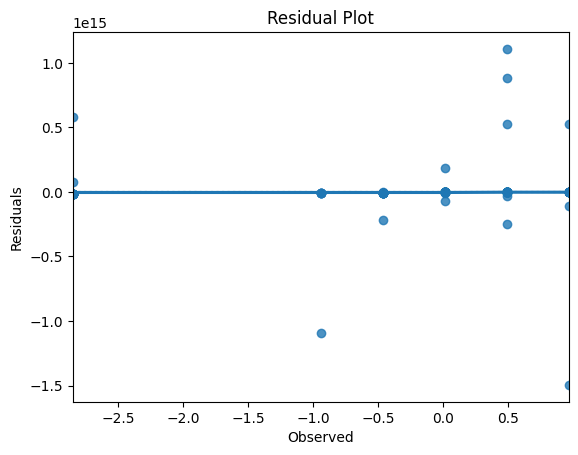

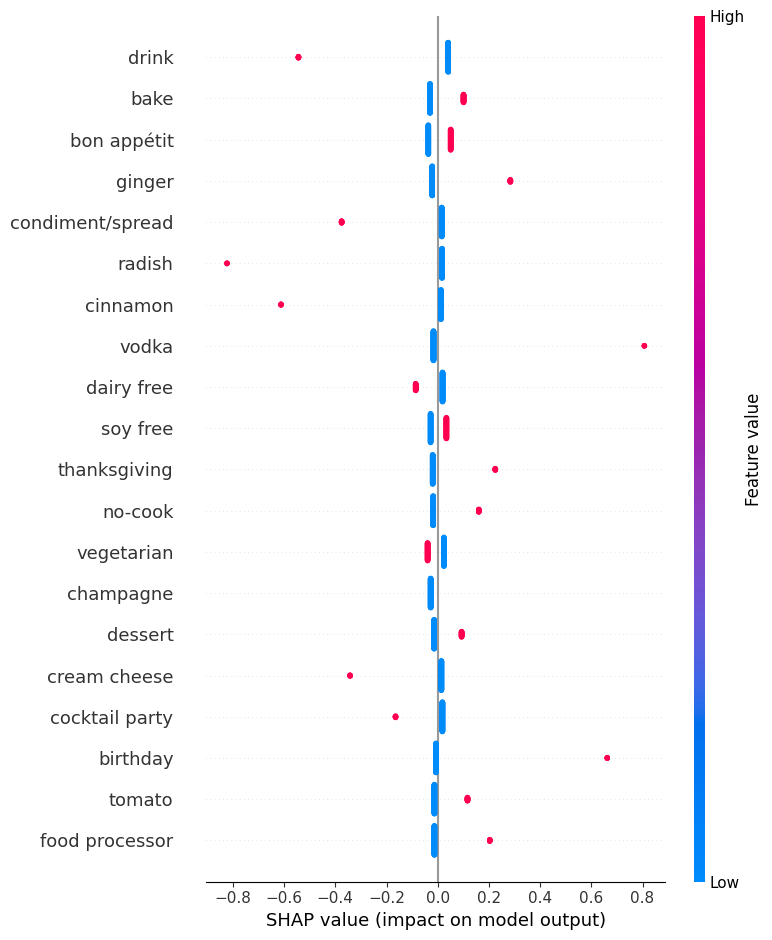

In [10]:
# Residual Plot
sns.residplot(x=y_test, y=y_pred, lowess=True)
plt.xlabel("Observed")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

# SHAP Visualization
explainer = shap.Explainer(ridge_cv.best_estimator_, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test)


In [11]:
#GridSearchCV in the ridge regression
ridge_params = {'alpha': [0.1, 1, 10, 100]}
ridge_cv = GridSearchCV(ridge, ridge_params, cv=5, scoring='r2')
ridge_cv.fit(X_train, y_train)
print(f"Best Ridge Alpha: {ridge_cv.best_params_}")

#GridSearchCV in the lasso regression
lasso = Lasso()
lasso_params = {'alpha': [0.1, 1, 10, 100]}
lasso_cv = GridSearchCV(lasso, lasso_params, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)
print(f"Best Lasso Alpha: {lasso_cv.best_params_}")

Best Ridge Alpha: {'alpha': 100}
Best Lasso Alpha: {'alpha': 0.1}


In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Decision Tree Regressor
dt = DecisionTreeRegressor(random_state=42)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)
print(f"Decision Tree -> R²: {r2_score(y_test, y_pred_dt):.2f}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_dt)):.2f}")

# Random Forest Regressor
rf = RandomForestRegressor(random_state=42, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
print(f"Random Forest -> R²: {r2_score(y_test, y_pred_rf):.2f}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}")

# Gradient Boosted Trees
gbt = GradientBoostingRegressor(random_state=42, n_estimators=100)
gbt.fit(X_train, y_train)
y_pred_gbt = gbt.predict(X_test)
print(f"Gradient Boosted Trees -> R²: {r2_score(y_test, y_pred_gbt):.2f}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_gbt)):.2f}")


Decision Tree -> R²: -0.91, RMSE: 1.44
Random Forest -> R²: -0.08, RMSE: 1.09
Gradient Boosted Trees -> R²: -0.01, RMSE: 1.05


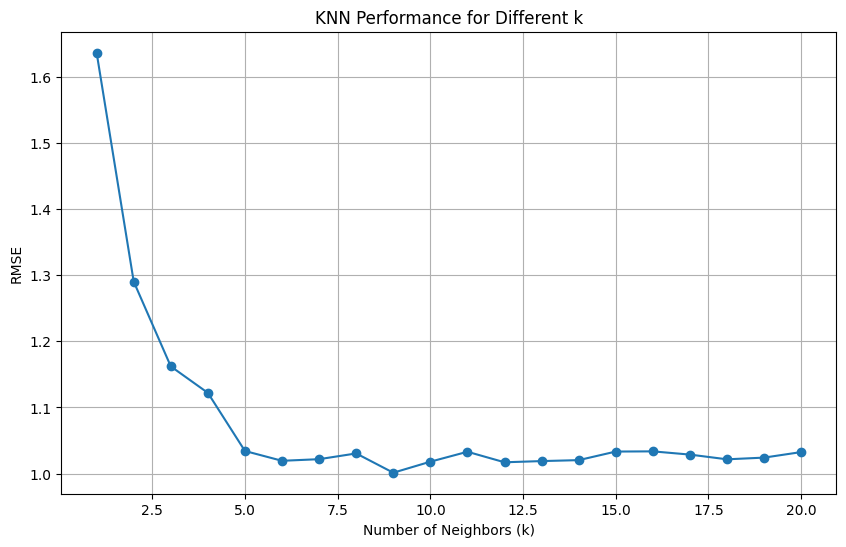

Optimal k for KNN: 9
KNN (k=9) -> R²: 0.08, RMSE: 1.00


In [13]:
from sklearn.neighbors import KNeighborsRegressor

# Test various k values
k_values = range(1, 21)
rmse_scores = []

for k in k_values:
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_knn = knn.predict(X_test)
    rmse_scores.append(np.sqrt(mean_squared_error(y_test, y_pred_knn)))

# Plot RMSE vs k
plt.figure(figsize=(10, 6))
plt.plot(k_values, rmse_scores, marker='o')
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("RMSE")
plt.title("KNN Performance for Different k")
plt.grid()
plt.show()

# Find optimal k
optimal_k = k_values[np.argmin(rmse_scores)]
print(f"Optimal k for KNN: {optimal_k}")

# Train KNN with optimal k
knn_optimal = KNeighborsRegressor(n_neighbors=optimal_k)
knn_optimal.fit(X_train, y_train)
y_pred_knn_optimal = knn_optimal.predict(X_test)
print(f"KNN (k={optimal_k}) -> R²: {r2_score(y_test, y_pred_knn_optimal):.2f}, RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_knn_optimal)):.2f}")


In [14]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Discretize target into bins for classification-like metrics
y_train_class = pd.cut(y_train, bins=3, labels=[0, 1, 2])
y_test_class = pd.cut(y_test, bins=3, labels=[0, 1, 2])

# Evaluate KNN as an example
knn_optimal.fit(X_train, y_train_class)
y_pred_knn_class = knn_optimal.predict(X_test)

# Convert predictions to class labels
y_pred_knn_class = pd.cut(y_pred_knn_class, bins=3, labels=[0, 1, 2]) # Discretize the predictions

print(f"Accuracy: {accuracy_score(y_test_class, y_pred_knn_class):.2f}")
print(f"Precision: {precision_score(y_test_class, y_pred_knn_class, average='weighted'):.2f}")
print(f"Recall: {recall_score(y_test_class, y_pred_knn_class, average='weighted'):.2f}")
print(f"F1-Score: {f1_score(y_test_class, y_pred_knn_class, average='weighted'):.2f}")

Accuracy: 0.41
Precision: 0.74
Recall: 0.41
F1-Score: 0.48


In [15]:
!pip install scikit-learn  # Ensure scikit-learn is installed

# Import necessary modules
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier  # Import KNeighborsClassifier

# ... rest of your code ...

precision_scores = []
recall_scores = []
f1_scores = []

for k in k_values:
    # Use KNeighborsClassifier for classification
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train_class)
    y_pred = knn.predict(X_test)

    # Ensure y_pred and y_test_class are of the same type (categorical)
    # This conversion might not be necessary if y_pred is already categorical
    y_pred = pd.Categorical(y_pred, categories=y_test_class.cat.categories)

    precision_scores.append(precision_score(y_test_class, y_pred, average='weighted'))
    recall_scores.append(recall_score(y_test_class, y_pred, average='weighted'))
    f1_scores.append(f1_score(y_test_class, y_pred, average='weighted'))

# Plot metrics (rest of the code remains the same)
# ...

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/m